In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.core.debugger import set_trace
%matplotlib inline

global ret,mtx,dist,M_persp,LeftLane,RightLane,frame_count

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last 5 fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last 5 iterations
        self.bestx = None
        # poly coeffs of the last 5 fits of the line
        self.recent_best_fit = []
        #polynomial coefficients averaged over the last 5 iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Number of frames for which averaged values were utilized
        self.frame_reuse_count = 0
        #Stat to keep track of total nuber of frame reusage for whole video
        self.total_frame_reuse = 0
    
    def total_frame_reuse(self):
        """
        This function returns the total frame re-use through-out the video
        i.e. all the frames which ended up utilizing the AverageX-Coordinates stored
        in recent_xfitted as well as the Poly coeffs stored in best_fit because their Sanity Check
        failed.
        """
        return self.total_frame_reuse
    
    def consec_frame_data_reuse_count(self):
        """
        This function returns the total number of consecutive frames shoe Sanity Check had failed
        and had to re-use the values stored in recent_xfitted and best_fit
        """
        return self.frame_reuse_count
    
    def get_xfits_poly_coeffs(self,is_avg_needed):
        """
        This functions returns either the average value of X-coordinates and average value of poly coeffs
        of previous frames or returns the X-coordinate/Poly-coeffs of the last frame encountered.
        """
        if( (len(self.recent_xfitted) == 2) and (is_avg_needed == True) ):
            return self.bestx,self.best_fit
        else:
            #set_trace()
            return self.recent_xfitted[-1],self.recent_best_fit[-1]
        
    def is_detected(self):
        return self.detected
    
    def set_detected(self,val):
        self.detected = val
    
    def increment_frame_reuse(self):
        self.frame_reuse_count+=1
        self.total_frame_reuse+=1
    
    def append_fits(self, xfit,poly_coeff):
        """
        Adds new xFit data and poly coeffs for the processed frame to recent_xfitted/recent_best_fit
        modifies the average stored in bestx/best_fit and resets the frame_reuse_count.
        """
        if(len(self.recent_xfitted) == 2):
            #Remove oldest fit, from start of the list to make space for new entry
            del self.recent_xfitted[0]
            del self.recent_best_fit[0]
        
        #Update the new recent xfitted value to end of list
        self.recent_xfitted.append(xfit)
        self.recent_best_fit.append(poly_coeff)
        
        #Update the poly coeffs of the current fit
        self.current_fit = poly_coeff
        
        if(len(self.recent_xfitted) == 2):
            #Update the average xfitted value over the content of the list
            self.bestx = np.average(self.recent_xfitted,axis=0,weights=[0.95,0.05])
            #Update the average poly coeffs 
            self.best_fit = np.average(self.recent_best_fit,axis=0,weights=[0.95,0.05])
        
        #If new data is being appended, that means that either this was a result
        #of a blind search being successful or Sanity check returning true for an extrapolated frame.
        #Reset the frame re-use count
        self.frame_reuse_count = 0

            
    def clear_fits(self):
        """
        Thi function clears all stored parameters of previous frames because the frame-reuse count
        has exceeded a threshold and extrapolation or parameter re-use of previous frames is no longer
        possible and a Blind search is needed for the next processed frame.
        """
        # x values of the last 30 fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last 5 iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last 5 iterations
        self.best_fit = None
        # poly coeffs of the last 5 fits of the line
        self.recent_best_fit = []
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #Reset the frame re-use count
        self.frame_reuse_count = 0
        #Reset the detected flag
        self.detected = False
    
    def clear_detected_reuse(self):
        self.frame_reuse_count = 0
        #Reset the detected flag
        self.detected = False
        
#Define two class instances for left and right lanes to be used later
LeftLane = Line()
RightLane = Line()

In [3]:
def DumpLaneStats(img):
    """
    This function dumps some statistics to a file while processing each frame
    and saves the results of each processed frame of the video.
    """
    global LeftLane,RightLane,frame_count
    with open('Stats.txt', 'a') as the_file:
        the_file.write('Frame:'+str(frame_count)+' '+ str(LeftLane.consec_frame_data_reuse_count()))
        the_file.write('\n')
    f_str = 'frame_op/frame_'+str(frame_count)+'.jpg'
    undist_img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(f_str,undist_img)

## Image Pre-processing functions:

In [4]:
#Helper functions
def CalibCamera():
    """
    This function is responsible for Camera Calibration using all the provided Chessboard images.
    """
    #Number of interior corners to be detected ideally
    corn_Y = 9
    corn_X = 6
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images by filename
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list of filenames, read them in, and search for chessboard corners
    for f_img in images:
        #Tempory storage of number of corners to be detected ideally.
        tmp_corn_y = corn_Y
        tmp_corn_x = corn_X
        img = cv2.imread(f_img)
        gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        #Try to detect ideal number of corners first and keep trying
        #with decreasing number of Y and X corners if required.
        ret = False
        for y_corn_n in range(corn_Y,3,-1):
            for x_corn_n in range(corn_X,3,-1):
                ret, corners = cv2.findChessboardCorners(gray_img,(y_corn_n,x_corn_n),None)
                if ret == True:
                    #print("Corners detected for Image:",f_img,"with Y and X as:", y_corn_n,x_corn_n)
                    obj_actual = np.zeros(((y_corn_n*x_corn_n),3),np.float32)
                    obj_actual[:,:2] = np.mgrid[0:y_corn_n,0:x_corn_n].T.reshape(-1,2)
                    
                    #append the object points and image points
                    objpoints.append(obj_actual)
                    imgpoints.append(corners)
                    
                    # Draw and display the corners
                    corn_img = cv2.drawChessboardCorners(img, (y_corn_n,x_corn_n), corners, ret)
                    #plt.imshow(corn_img)
                    #plt.figure()
                    break
            if ret == True:
                break
        
        if ret == False:
            print("No corners detected for Image",f_img)
    
    #Calibrate the camera now
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray_img.shape[::-1],None,None)
    return ret,mtx,dist

def UndistortImg(img,mtx,dist):
    """
    This function undistorts incoming image and returns the undistorted result.
    """
    return cv2.undistort(img,mtx,dist,None,mtx)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
   
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    """
    This function returns a Binary image using the SobelX or Sobel Y gradient masks
    on the input image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=-1))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=-1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    This function returns a Binary image using the Magnitude of Sobel gradient
    on the input image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    This function returns a Binary image using the Direction of Sobel gradient
    on the input image.
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=-1)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=-1)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def col_thresh(image, channel='s'):
    """
    This function returns a Binary image by performing colour thresholding
    based on the input channel type on which thresholding is needed.
    """
    yellow_rgb = np.uint8([[[0,255,255 ]]])
    white_rgb = np.uint8([[[255,255,255]]])
    
    yellow_hls = cv2.cvtColor(yellow_rgb,cv2.COLOR_BGR2HLS)
    white_hls = cv2.cvtColor(white_rgb, cv2.COLOR_BGR2HLS)
    
    #LAB conversion of pure yellow
    yellow_lab = cv2.cvtColor(yellow_rgb,cv2.COLOR_BGR2LAB)
    
    if channel== 's':
        #return col_thresh_assist(image,channel,thresh=(170,255))
        return col_thresh_assist(image,channel,thresh=(100,255))
    elif channel == 'h':
        #Hue channel is being used for white as well as yellow mask
        
        yellow_l_thresh = max(yellow_hls[0,0,0]-10,0)
        yellow_h_thresh = min(yellow_hls[0,0,0]+10,179)
        #print(yellow_l_thresh,yellow_h_thresh)
        yellow_bin = col_thresh_assist(image,channel,thresh=(yellow_l_thresh,yellow_h_thresh))
        
        white_l_thresh = max(white_hls[0,0,0]-10,0)
        white_h_thresh = min(white_hls[0,0,0]+10,179)
        #print(white_l_thresh,white_h_thresh)
        white_bin = col_thresh_assist(image,channel,thresh=(white_l_thresh,white_h_thresh))
        
        comb_h_bin = np.zeros_like(image[:,:,0])
        comb_h_bin[(white_bin==1)|(yellow_bin==1)] = 1
        return comb_h_bin
    elif channel == 'b':
        yellow_l_thresh = max(yellow_lab[0,0,2]-40,0)
        yellow_h_thresh = min(yellow_lab[0,0,2]+30,255)
        return col_thresh_assist(image,channel,thresh=(yellow_l_thresh,yellow_h_thresh))
    elif channel == 'l':
        white_l_thresh = max(white_hls[0,0,1]-20,0)
        white_h_thresh = min(white_hls[0,0,1]+10,255)
        return col_thresh_assist(image,channel,thresh=(white_l_thresh,white_h_thresh)) 
    elif channel == 'v':
        return col_thresh_assist(image,channel,thresh=(50,255))

def col_thresh_assist(image, channel,thresh=(170,255)):
    """
    This function is a helper function to col_thresh and assits in thresholing
    based on min and max range of threshold.
    """
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    im_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    if channel == 's':
        ch = hls[:,:,2]
    elif channel == 'h':
        ch = hls[:,:,0]
    elif channel == 'b':
        ch = im_lab[:,:,2]
    elif channel == 'l':
        ch = hls[:,:,1]
    elif channel == 'v':
        ch = hsv[:,:,2]

    # Threshold color channel
    s_binary = np.zeros_like(ch)
    s_binary[(ch >= thresh[0]) & (ch <= thresh[1])] = 1
    return s_binary

def Thresholding(img):
    """
    This function combines the results of all thresholding methods
    and returns a binary image.
    """
    show_plt_flag = False
    #Default option chosen for thresholding is:
    # (GradX & GradY)|(Saturation & Value)
    comb_opt_toggle = 5
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    if show_plt_flag == True:
        plt.imshow(gradx,cmap='gray')
        plt.figure()
    
    #prev was 80 to 150
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    if show_plt_flag == True:
        plt.imshow(grady,cmap='gray')
        plt.figure()
        
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.4, 1.0))
    
    #Saturation based thresholding of the HSV colour space.
    col_binary_s = col_thresh(img, channel='s')
    if show_plt_flag == True:
        plt.imshow(col_binary_s,cmap='gray')
        plt.figure()
    
    #Hue based thresholding of the HSV colour space
    col_binary_h = col_thresh(img, channel='h')
    
    #B channel based thresholding of the LAB colour space
    col_binary_b = col_thresh(img, channel='b')
    
    #L channel based thresholding of the HSL colour space
    col_binary_l = col_thresh(img, channel='l')
    
    # V channel based thresholding of the HSV colour space
    col_binary_v = col_thresh(img, channel='v')
    if show_plt_flag == True:
        plt.imshow(col_binary_v,cmap='gray')
        plt.figure()

    combined = np.zeros_like(dir_binary)
    if comb_opt_toggle == 1:
        combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))| ((col_binary_s == 1)&(grady == 1))| ((col_binary_s == 1)&(col_binary_h == 1))] = 1
    elif comb_opt_toggle == 2:
        combined[(gradx == 1)|((col_binary_s == 1)&(grady == 1))] = 1
    elif comb_opt_toggle == 3:
        combined[((gradx == 1)) | ((col_binary_s == 1))| ((col_binary_h == 1))] = 1
    elif comb_opt_toggle == 4:
        combined[((col_binary_b == 1)|(col_binary_l == 1)|(gradx == 1) | (col_binary_s == 1))] = 1
    elif comb_opt_toggle == 5:
        combined[(((gradx == 1)&(grady == 1))|((col_binary_s == 1)&(col_binary_v == 1)))] = 1        
    
    
    if show_plt_flag == True:
        tmp_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(tmp_img)
        plt.figure()
        plt.imshow(combined,cmap='gray')
        plt.figure()
    
    return combined

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

#Not used
def color_select(image):
    """
    This function is used for Colour selection of yellow and white colours to overlay on top
    of original image in order to assist Colour based thresholding methods.
    """
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    yellow_rgb = np.uint8([[[0,255,255 ]]])
    white_rgb = np.uint8([[[255,255,255]]])
    
    yellow_hsv = cv2.cvtColor(yellow_rgb,cv2.COLOR_BGR2HSV)
    white_hsv = cv2.cvtColor(white_rgb, cv2.COLOR_BGR2HSV)
    
    # Convert BGR to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # define range of yellow and white color in HSV
    yellow_low_hue = yellow_hsv[0,0,0]-np.uint8(20)
    yellow_high_hue = yellow_hsv[0,0,0]+np.uint8(20)

    #print(yellow_low_hue,yellow_high_hue)
    
    yellow_low_sat = yellow_hsv[0,0,1]-np.uint8(200)
    yellow_high_sat = yellow_hsv[0,0,1]

    #print(yellow_low_sat,yellow_high_sat)
    
    yellow_low_val = yellow_hsv[0,0,2]-np.uint8(200)
    yellow_high_val = yellow_hsv[0,0,2]
    
    #print(yellow_low_val,yellow_high_val)
    
    white_low_hue = white_hsv[0,0,0]
    white_high_hue = white_hsv[0,0,0]+ np.uint8(140)

    #print(white_low_hue,white_high_hue)
    white_low_sat = white_hsv[0,0,1]
    white_high_sat = white_hsv[0,0,1] + np.uint8(20)
    
    #print(white_low_sat,white_high_sat)
    
    white_low_val = white_hsv[0,0,2]-np.uint8(100)
    white_high_val = white_hsv[0,0,2]

    #print(white_low_val,white_high_val)
    
    
    lower_yellow = np.array([yellow_low_hue,yellow_low_sat,yellow_low_val])
    upper_yellow = np.array([yellow_high_hue,yellow_high_sat,yellow_high_val])
    lower_white = np.array([white_low_hue,white_low_sat,white_low_val])
    upper_white = np.array([white_high_hue,white_high_sat,white_high_val])

    # Threshold the HSV image to get only yellow and white colours
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    combined_mask = yellow_mask | white_mask
    #Make the combined mask #dimensional for the HSV layers
    combined_mask = np.dstack((combined_mask, combined_mask, combined_mask)) 
    
    # Bitwise-AND mask and original image
    thresh_img_hsv = cv2.bitwise_and(hsv_image,combined_mask)
    thresh_img_bgr = cv2.cvtColor( thresh_img_hsv,cv2.COLOR_HSV2BGR )
    return thresh_img_bgr


# Functions for Generating X-fits and Poly-fits for Frames

In [5]:
def LanefitFirst(binary_warped,f_img='',is_frame=False):
    """
    This function generates the xfit and the polyfit coeffs for the left and right lanes
    by performing a Blind Window search
    """
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #is_frame will be False when this function is called on sample test-images
    #for which images need to be saved and plotted. Otherwise true when used
    #for processing each frame of the video.
    if is_frame == False:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(f_img)
        plt.figure()
    
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        f_str = 'shadow_window_images/'+f_img.split('/')[-1]
        plt.savefig(f_img)
        plt.figure()
    else:
        return left_fitx,right_fitx,left_fit,right_fit,ploty
            
    



In [6]:
def ExtrapolatedLaneFit(binary_warped,left_fit,right_fit):
    """
    This function generates the xfit and polyfit coeffs for a frame by utilizing the polyfit coeffs
    of the previously generated polyfit coefficients.
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                                                                         left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                                                           right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    return left_fitx,right_fitx,left_fit_new,right_fit_new,ploty


In [7]:
def SanityCheck(left_fitx,right_fitx):
    """
    This function performs a sanity check on the generated xfit data for the left and right lanes
    and returns True if the average width of the detected lane does not deviate by a threshold greater
    than the actual lane width
    """
    
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    thresh = 0.3 #in meters
    
    #Find average of the difference of the x coordinates of the right and the left lanes
    avg_dist_px = np.mean(right_fitx - left_fitx)
    #Avg distance in meters
    avg_dist_m = avg_dist_px*xm_per_pix
    
    #If the average distance in metres if off from the actual distance of 3.7 m by > thresh , return False
    if(abs(avg_dist_m-3.7) > thresh):
        return False
    else:
        return True
    

In [8]:
def Curv_Dist_Cent(leftx,rightx,ploty,leftfit,rightfit):
    """
    This function generats the Radius of curvature for the left and right lanes
    and the Distance of the center of the lanes from the center of the image.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/1280 # meters per pixel in x dimension
    h,w = 720,1280

    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    car_pos = 1280/2
    l_fit_x_int = leftfit[0]*h**2 + leftfit[1]*h + leftfit[2]
    r_fit_x_int = rightfit[0]*h**2 + rightfit[1]*h + rightfit[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_pos - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist



In [9]:
def Curv_Rad_Text(img, curv_rad_left, curv_rad_right, center_dist):
    """
    This function superimposes text pertaining to the Radius of curvature and Distance
    from center on the processed image frame.
    """
    h = img.shape[0]
    font = cv2.FONT_HERSHEY_PLAIN
    text = 'Radius of Curvature of Left Lane: ' + '{:04.2f}'.format(curv_rad_left) + 'm'
    cv2.putText(img, text, (50,80), font, 2.0, (0,0,0), 2, cv2.LINE_AA)
    text = 'Radius of Curvature of Right Lane: ' + '{:04.2f}'.format(curv_rad_right) + 'm'
    cv2.putText(img, text, (50,150), font, 2.0, (0,0,0), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (50,220), font, 2.0, (0,0,0), 2, cv2.LINE_AA)
    return img

In [10]:
def Pipeline(img,mtx,dist,M):
    """
    This function defines the pipeline for processing an incoming image, predicting the lane windows
    for the left and right lanes, overlaying the detected lane on top of the original image along
    with the radius of curvature data and offset from center.
    """
    global LeftLane,RightLane,frame_count
    
    frame_count+=1
    #Save the inverse transformation for wraping the result back to original image
    ret,Minv = cv2.invert(M)
    #print(M,Minv)
    #Convert to BGR since all functions below assume BGR input
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    
    #Undistort the image first
    undist_img = UndistortImg(img,mtx,dist)
    
    #threshold the image
    combined_thresh_img = Thresholding(undist_img)
    #thresh_3d = combined_thresh_img*255
    thresh_3d = np.dstack((combined_thresh_img,combined_thresh_img,combined_thresh_img))*255
    
    #Isolate the ROI of the frame.
    e_y = thresh_3d.shape[0]
    e_x = thresh_3d.shape[1]
    roi_img = region_of_interest(thresh_3d,np.array([[[40,e_y],[e_x/2,e_y/2+45],[e_x/2+30,e_y/2+65],[e_x,e_y]]],dtype=np.int32))
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(roi_img, M, (e_x,e_y))
    
    # First time estimate of left and right lane needs to be done by Blind search
    if LeftLane.is_detected() == False and RightLane.is_detected() == False:
        left_fitx,right_fitx,left_fit,right_fit,ploty = LanefitFirst(warped[:,:,0],is_frame=True)
    else:
        #Get the Poly coeffs of the last frame and use extrapolation rather than blind search
        left_fitx_prev,left_fit_prev = LeftLane.get_xfits_poly_coeffs(False)
        right_fitx_prev,right_fit_prev = RightLane.get_xfits_poly_coeffs(False)
        
        #Utilize the poly coeffs of the last frame to predict poly coeffs as well X-coords
        #of the lanes of this frame.
        left_fitx,right_fitx,left_fit,right_fit,ploty = ExtrapolatedLaneFit(warped[:,:,0],left_fit_prev,right_fit_prev)
    
    #Set the Left and Right Lane detected vars to True and no need for Sanity Check if
    #these values were obtained from a blind search
    if LeftLane.is_detected() == False and RightLane.is_detected() == False:
        LeftLane.set_detected(True)
        RightLane.set_detected(True)
        LeftLane.append_fits(left_fitx,left_fit)
        RightLane.append_fits(right_fitx,right_fit)
    else:
        #Sanity check is needed for the extrapolated frame
        res = SanityCheck(left_fitx,right_fitx)
        
        #If Sanity check returns true, then this extrapolated frame is good
        # and append the X-coords of the Lanes and their Polyfit Coeffs to storage
        if( res == True):
            LeftLane.append_fits(left_fitx,left_fit)
            RightLane.append_fits(right_fitx,right_fit)
        else:
            #Utilize averaged out values of X-coords of the Lanes from Storage
            #as well as Poly coeffs of the Lanes from Storage
            left_fitx,left_fit = LeftLane.get_xfits_poly_coeffs(True)
            right_fitx,right_fit = RightLane.get_xfits_poly_coeffs(True)
            
            #Increment the frame reusage counters for the Left and Right Lanes
            LeftLane.increment_frame_reuse()
            RightLane.increment_frame_reuse()
            
            #Previous frames X-coords as well as poly coeffs can be re-used for next 5 frames only
            #after which all buffered storage needs to be cleared and a blind window search has to be done
            #for the next frame
            if( LeftLane.consec_frame_data_reuse_count() == 5 ) or ( RightLane.consec_frame_data_reuse_count() == 5 ) :
                LeftLane.clear_fits()
                RightLane.clear_fits()
       
    
    #Radius of curvature and Distance from center calculation
    left_curverad, right_curverad, center_dist = Curv_Dist_Cent(left_fitx,right_fitx,ploty,left_fit,right_fit)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.array([pts],dtype=np.int32), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0]))
    
    #Convert the undistorted image back to RGB
    undist_img = cv2.cvtColor(undist_img,cv2.COLOR_BGR2RGB)
    # Combine the result with the original undistorted image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    #Superimpose the Curvature and Distance from center data on the image.
    result = Curv_Rad_Text(result,left_curverad, right_curverad, center_dist)
    
    return result
        
        
    

In [11]:
def process_image(img):
    """
    This function processes each incoming frame and generates the 
    output result.
    """
    global ret,mtx,dist,M_persp,frame_count
    res_img = Pipeline(img,mtx,dist,M_persp)
    DumpLaneStats(res_img)
    return res_img    

# Video Processing

In [12]:
#Calibrate camera
ret,mtx,dist = CalibCamera()
frame_count = 0
#Generate perspective transform matrix
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
# Given src and dst points, calculate the perspective transform matrix
M_persp = cv2.getPerspectiveTransform(src, dst)
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,25)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [07:29<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 37min 29s, sys: 30.9 s, total: 38min
Wall time: 7min 30s


# Pipeline operations on Sample Test Images

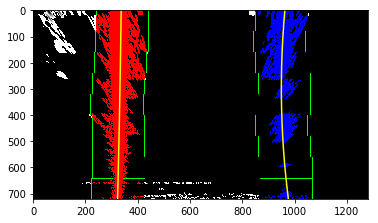

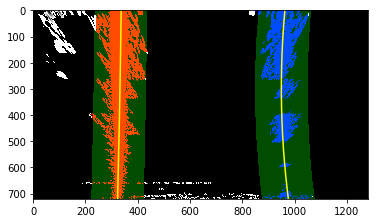

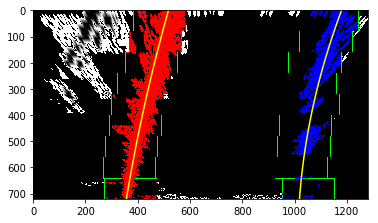

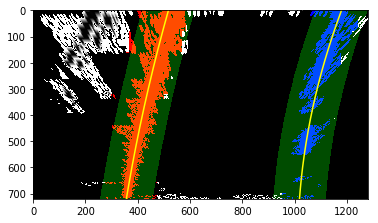

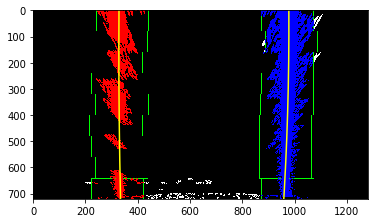

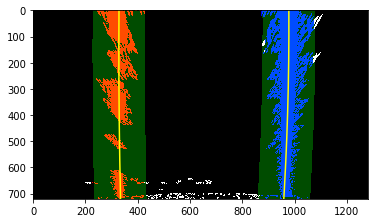

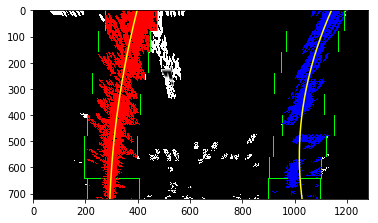

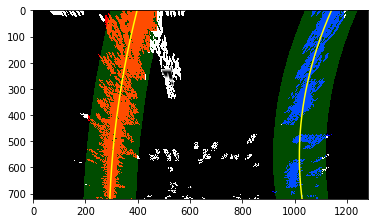

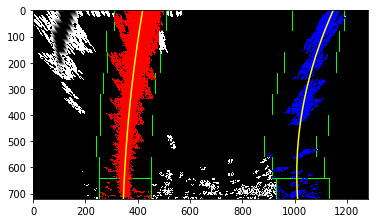

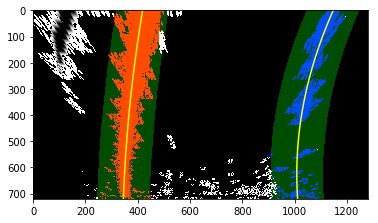

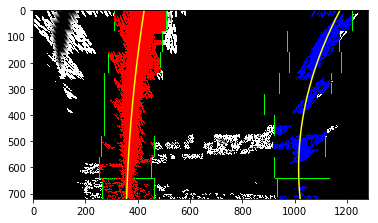

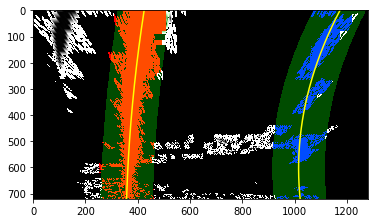

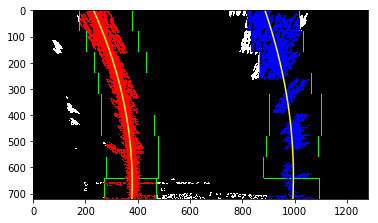

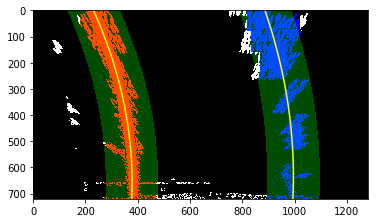

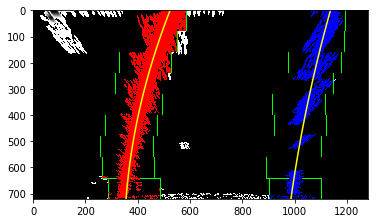

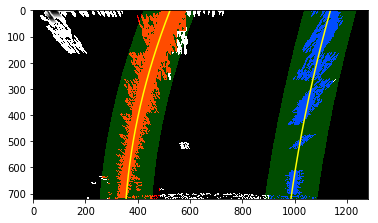

In [13]:
#Original Pipeline arch testing
#Operations on test-images
#Calibrate camera
ret,mtx,dist = CalibCamera()

#Undistort all chessboardimages
images = glob.glob('camera_cal/*.jpg')
for f_img in images:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    undist_img = UndistortImg(img,mtx,dist)
    f_str = 'camera_cal_op_images/'+f_img.split('/')[-1]
    undist_img = cv2.cvtColor(undist_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(f_str,undist_img)


#Undistort sample test images
images = glob.glob('test_images/*.jpg')
for f_img in images:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    undist_img = UndistortImg(img,mtx,dist)
    f_str = 'undist_images/'+f_img.split('/')[-1]
    undist_img = cv2.cvtColor(undist_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(f_str,undist_img)

#Perform Thresholding
images = glob.glob('undist_images/*.jpg')
for f_img in images:
    im1 = cv2.imread(f_img)
    # Apply each of the thresholding functions
    combined_thresh_img = Thresholding(im1)
    thresh_3d = np.dstack((combined_thresh_img,combined_thresh_img,combined_thresh_img))*255
    f_str = 'thresh_images/'+f_img.split('/')[-1]
    cv2.imwrite(f_str,thresh_3d)


#Perform ROI masking
images = glob.glob('thresh_images/*.jpg')
for f_img in images:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    e_y = img.shape[0]
    e_x = img.shape[1]
    roi_img = region_of_interest(img,np.array([[[40,e_y],[e_x/2,e_y/2+45],[e_x/2+30,e_y/2+65],[e_x,e_y]]],dtype=np.int32))
    f_str = 'roi_images/'+f_img.split('/')[-1]
    cv2.imwrite(f_str,roi_img)
    
#Perform Perspective Transform on ROIed images
images = glob.glob('roi_images/*.jpg')
for f_img in images:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    im_shp = img.shape
    e_y = im_shp[0]
    e_x = im_shp[1]
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                      [453./1280*w,547./720*h],
                      [835./1280*w,547./720*h],
                      [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (e_x,e_y))
    f_str = 'persp_images/'+f_img.split('/')[-1]
    cv2.imwrite(f_str,warped)

#Lane Fitting
images = glob.glob('persp_images/*.jpg')
for f_img in images:
    im1 = cv2.imread(f_img)
    f_str = 'window_images/'+f_img.split('/')[-1]
    LanefitFirst(im1[:,:,0],f_str,False)

